# Final Project – Module 1

### Import packages and datasets that will be used throughout investigation

In [60]:
#--- IMPORT NECESSARY PACKAGES ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf

#--- BASIC GLOBAL DECLARATIONS ---
pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

In [61]:
#--- IMPORT DATA FROM EXTERNAL CSVs ---

# basic title data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# movie basic details from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# wide ranging data from The Movie Database, largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path).drop('Unnamed: 0', axis=1)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

### Aggregate data from various sources to create one cohesive dataframe containing only relevant data

In [62]:
#--- COMBINE AND CLEAN FINANCIAL DATA ---

finance = tn_movie_budgets[['movie', 'production_budget', 
                            'domestic_gross','worldwide_gross']].copy()

# clean data: remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',','')) for x in finance.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in finance.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in finance.worldwide_gross]

# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

In [63]:
#--- CREATE LIST OF ALL POSSIBLE GENRES --- 

# Note: the current formatting shows multiple genres in each 
#       genre cell, separated by commas. The below analysis
#       instead creates a separate column for each genre and
#       represents the data as binary 1 or 0 to indicate whether
#       a given film is classified within that genre

genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []
for genre in genres_messy:
    for genre_split in genre.split(','):
        genres_clean.append(genre_split)
genres_clean = list(set(genres_clean))


df_genres = imdb_title_basics.loc[imdb_title_basics['genres'].isna() == False].copy()
for colname in genres_clean:
    df_genres[colname] = [colname in x for x in df_genres['genres']]

In [64]:
#--- DROP COLUMNS UNWANTED IN FINAL DATAFRAME ---

# Note that this should be kept in a separate cell since running it
# multiple times results in an error if the column is already dropped

imdb_title_basics.drop(['original_title', 'genres'], 
                       axis=1, inplace=True)

tmdb_movies.drop(['original_title', 'id', 'genre_ids', 
                  'original_language'], axis=1, inplace=True)

df_genres.drop(['start_year', 'runtime_minutes', 'genres', 
                'original_title', 'primary_title'], axis=1, inplace=True)

# renaming now makes future SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})


In [65]:
#--- CREATE DATAFRAME THAT AGGREGATES ALL RELEVANT DATA FROM ALL RELEVANT SOURCES ---
q = '''
SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN df_genres USING (tconst);'''

# Use SQL to connect relevant dataframes
all_data = pysqldf(q)

genre_dict = {
'Action': 'genre_action',
'Adult': 'genre_adult',
'Adventure': 'genre_adventure',
'Animation': 'genre_animation',
'Biography': 'genre_biography',
'Comedy': 'genre_comedy',
'Crime': 'genre_crime',
'Documentary': 'genre_documentary',
'Drama': 'genre_drama',
'Family': 'genre_family',
'Fantasy': 'genre_fantasy',
'Game-Show': 'genre_gameshow',
'History': 'genre_history',
'Horror': 'genre_horror',
'Music': 'genre_music',
'Musical': 'genre_musical',
'Mystery': 'genre_mystery',
'News': 'genre_news',
'Reality-TV': 'genre_realitytv',
'Romance': 'genre_romance',
'Sci-Fi': 'genre_scifi',
'Short': 'genre_short',
'Sport': 'genre_sport',
'Talk-Show': 'genre_talkshow',
'Thriller': 'genre_thriller',
'War': 'genre_war',
'Western': 'genre_western',
}

#update column names using above dictionary
col_names = []
for col in all_data.columns:
    if col in genre_dict.keys():
        col_names.append(genre_dict[col])
    else:
        col_names.append(col)
all_data.columns = col_names


# convert "None" values/types to NaN for easier manipulation and consistency
all_data.fillna(value=np.nan, inplace=True) 

## Begin Analysis of Data

In [66]:
# --- AGGREGATE DATA *FOR EACH GENRE* INTO ONE DATAFRAME ---
GENRES = list(genre_dict.values())
df_genres = pd.DataFrame(genre_dict.keys(), GENRES)
df_genres.reset_index(inplace=True)
df_genres.columns = ['genre_long', 'genre']

In [67]:
# --- START WITH FINANCIALS ---
profit_median = []
profit_mean = []
for genre in GENRES:
    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[genre] == True), 'profit']
    profit_median.append(profit.median())
    profit_mean.append(profit.mean())
    
df_genres['profit_median'] = profit_median
df_genres['profit_mean'] = profit_mean


# --- PROFITABILITY RANK ---
df_genres.sort_values(by='profit_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['profit_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['profit_median'])
# plt.title('Median Profit by Genre ($)')
# plt.show()

In [68]:
# --- POPULARITY ---

popularity_median = []
popularity_mean = []
for genre in GENRES:
    popularity = all_data.loc[(all_data['popularity'].isna() == False) &
                          (all_data[genre] == True), 'popularity']
    popularity_median.append(popularity.median())
    popularity_mean.append(popularity.mean())
    
df_genres['popularity_median'] = popularity_median
df_genres['popularity_mean'] = popularity_mean


# --- POPULARITY RANK ---
df_genres.sort_values(by='popularity_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['popularity_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)

# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['popularity_median'])
# plt.title('Median Popularity by Genre')
# plt.show()

In [69]:
# --- VOTE AVG ---
MIN_VOTE_CT = 5

vote_median = []
vote_mean = []
for genre in GENRES:
    vote = all_data.loc[(all_data['vote_average'].isna() == False) &
                        (all_data['vote_count'] >= MIN_VOTE_CT) &
                          (all_data[genre] == True), 'vote_average']
    vote_median.append(vote.median())
    vote_mean.append(vote.mean())
    
df_genres['vote_median'] = vote_median
df_genres['vote_mean'] = vote_mean

# --- VOTE RANK ---
df_genres.sort_values(by='vote_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['vote_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['vote_median'])
# plt.title('Median Vote by Genre')
# plt.show()

In [70]:
all_data

,tconst,primary_title,start_year,runtime_minutes,production_budget,domestic_gross,worldwide_gross,profit,popularity,release_date,...,genre_news,genre_documentary,genre_family,genre_horror,genre_short,genre_crime,genre_gameshow,genre_biography,genre_adult,genre_war
0,tt0063540,Sunghursh,2013,175.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,tt0066787,One Day Before the Rainy Season,2019,114.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,tt0069049,The Other Side of the Wind,2018,122.0,NaN,NaN,NaN,NaN,9.8,2018-11-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0069204,Sabse Bada Sukh,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0100275,The Wandering Soap Opera,2017,80.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150825,tt9916538,Kuambil Lagi Hatiku,2019,123.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150826,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150827,tt9916706,Dankyavar Danka,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150828,tt9916730,6 Gunn,2017,116.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# --- MOVIE CT ---
MIN_MOVIE_CT = 500

movie_ct = []
for genre in GENRES:
    ct = all_data.loc[(all_data[genre] == True), genre]
    movie_ct.append(ct.sum())
    
df_genres['movie_ct'] = movie_ct

df_genres

,genre_long,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,vote_median,vote_mean,vote_rank,movie_ct
0,genre_western,Western,-2541971.0,1.748987e+07,22,1.6255,3.242104,17,6.90,6.755556,0,10806.0
1,genre_documentary,Documentary,7685268.0,5.307152e+07,14,1.5395,3.822943,18,6.80,6.800000,1,25.0
2,genre_romance,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,4,6.75,6.616344,2,6737.0
3,genre_adult,Adult,NaN,NaN,23,2.4070,2.407000,7,6.70,6.523186,3,2906.0
4,genre_comedy,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,12,6.60,6.543830,4,8990.0
5,genre_music,Music,8462398.0,1.288383e+08,13,1.9530,3.630725,14,6.60,6.451143,5,25948.0
6,genre_horror,Horror,6898293.0,4.563700e+07,15,1.2375,4.587429,22,6.50,6.406818,6,7132.0
7,genre_animation,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,6.40,6.353398,7,52537.0
8,genre_musical,Musical,64950630.5,2.922556e+08,1,0.6965,0.696500,25,6.20,6.183770,8,52267.0
9,genre_family,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,15,6.10,6.074775,9,6462.0


In [72]:
df_genres.sort_values(by='genre')

,genre_long,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,vote_median,vote_mean,vote_rank,movie_ct
17,genre_action,Action,25023759.0,1.097484e+08,6,3.0990,5.194202,5,5.90,5.844625,17,1562.0
3,genre_adult,Adult,NaN,NaN,23,2.4070,2.407000,7,6.70,6.523186,3,2906.0
25,genre_adventure,Adventure,57375039.0,1.904184e+08,2,4.4065,7.857636,1,2.10,2.100000,25,1474.0
7,genre_animation,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,6.40,6.353398,7,52537.0
11,genre_biography,Biography,9876855.0,4.926510e+07,12,1.4000,3.712482,19,6.10,6.059592,11,5.0
4,genre_comedy,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,12,6.60,6.543830,4,8990.0
10,genre_crime,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,9,6.10,6.008638,10,3682.0
1,genre_documentary,Documentary,7685268.0,5.307152e+07,14,1.5395,3.822943,18,6.80,6.800000,1,25.0
18,genre_drama,Drama,4797192.0,4.173338e+07,17,0.6600,1.733840,26,5.90,5.692593,18,99.0
9,genre_family,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,15,6.10,6.074775,9,6462.0


In [73]:
TOP_CT = 20
min_movie_ct = 500

df_genres = df_genres.loc[(df_genres['profit_rank'] <= TOP_CT) & 
                          (df_genres['popularity_rank'] <= TOP_CT) & 
                          (df_genres['vote_rank'] <= TOP_CT) &
                          (df_genres['movie_ct'] >= min_movie_ct)]

,genre_long,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,vote_median,vote_mean,vote_rank,movie_ct
2,genre_romance,Romance,12211455.5,5.258693e+07,10,3.7175,6.810780,4,6.75,6.616344,2,6737.0
4,genre_comedy,Comedy,15275343.5,7.148983e+07,8,2.0370,4.071102,12,6.60,6.543830,4,8990.0
5,genre_music,Music,8462398.0,1.288383e+08,13,1.9530,3.630725,14,6.60,6.451143,5,25948.0
7,genre_animation,Animation,85294313.5,1.940365e+08,0,3.7480,6.619390,3,6.40,6.353398,7,52537.0
9,genre_family,Family,36627518.0,1.283730e+08,4,1.9355,4.265355,15,6.10,6.074775,9,6462.0
10,genre_crime,Crime,2434356.0,3.733343e+07,20,2.3780,5.539034,9,6.10,6.008638,10,3682.0
12,genre_sport,Sport,3253717.5,6.474102e+07,19,2.3790,4.282739,8,6.10,6.059710,12,6376.0
14,genre_history,History,11507410.0,5.656655e+07,11,3.9030,3.897000,2,6.00,5.920684,14,5755.0
15,genre_news,News,28031715.0,2.208677e+07,5,2.2130,4.349066,10,5.90,5.728079,15,1470.0
16,genre_war,War,4856688.0,3.903443e+07,16,2.5520,4.599446,6,5.90,5.877435,16,4940.0


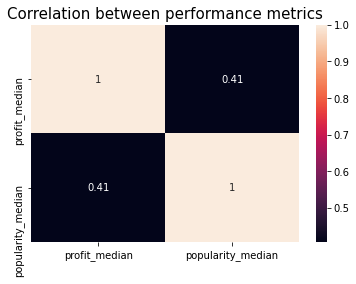

In [74]:
corrMatrix = df_genres[['profit_median', 'popularity_median']].dropna().corr()
#corrMatrix = tester[['profit_mean', 'popularity_mean']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between performance metrics", fontsize=15)
df_genres

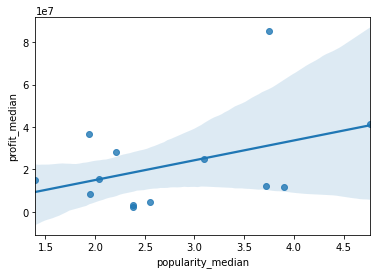

In [75]:
x = df_genres.popularity_median
y = df_genres.profit_median
# use the function regplot to make a scatterplot
sns.regplot(x,y)
plt.show()

# Notes From Call with Joel

- Consider frequency that each genre is produced. 

- Is there anything in this data that says starting with high popularity could lead to later profitability?

- If popularity is so vital, need to define more clearly how that is narrowed. Then, take a look at the most popular movies; profile these aspects to see "what works" and what doesn't

- Consider budgets too since that is especially relevant to companies breaking into a market

- Anything from Runtime?

- Look into top actors -- this could be something they would "need" to have in new films

- Try to create distinction between that the popular and unpopular factors are

- Tell them "what they should care about, and what they shouldn't care about". Second point is less necessary, but can be helpful

- Popular includes number of films produced in that genre, not just ratings

- Also look at distributions of this data, not just median. The company will also care about the confidence interval for these calculations.

For cutting off outliers: get rid of 2* std_dev

For cases where that can't be used, if there are tons of 1's and 2's like we see in studios, how do we choose what minimum values are to cut off? One possible way: identify examples of studios you're actually interested in. One thing to narrow based on is consistency of production over time. 

### Graphics showing metrics only for genres deemed relevant above

To be used in final presentation

In [76]:
# --- POPULARITY ---
MIN_VOTE_CT = 5

vote_median = []
vote_mean = []
for genre in GENRES:
    vote = all_data.loc[(all_data['vote_average'].isna() == False) &
                        (all_data['vote_count'] >= MIN_VOTE_CT) &
                          (all_data[genre] == True), 'vote_average']
    vote_median.append(vote.median())
    vote_mean.append(vote.mean())
    
df_genres['vote_median'] = vote_median
df_genres['vote_mean'] = vote_mean

# --- VOTE RANK ---
df_genres.sort_values(by='vote_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['vote_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['vote_median'])
# plt.title('Median Vote by Genre')
# plt.show()

ValueError: Length of values does not match length of index

In [ ]:
##### DOES POPULARITY LEAD TO PROFITABILITY?

CATEGORY = 'profit'
median = {}
for g in GENRES:
    temp = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data[CATEGORY].isna() == False) &
                        (all_data[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_profit = pd.DataFrame(median.items())


CATEGORY = 'popularity'
median = {}
for g in GENRES:
    temp = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data[CATEGORY].isna() == False) &
                        (all_data[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_popularity = pd.DataFrame(median.items())


q = '''SELECT * FROM df_profit JOIN df_popularity USING ('0');'''
df = pysqldf(q)
df.columns = ['genre', 'profit', 'popularity']


df = all_data[['tconst', 'profit', 'popularity']].dropna().reset_index(drop=True)
QUANTILE = 0.01
df = df.loc[(df.profit >= df.profit.quantile(QUANTILE)) & (df.profit <= df.profit.quantile(1-QUANTILE))].copy()
df = df.loc[(df.popularity >= df.popularity.quantile(QUANTILE)) & (df.popularity <= df.popularity.quantile(1-QUANTILE))].copy()

x = df.popularity
y = df.profit
# use the function regplot to make a scatterplot
sns.regplot(x,y)
#sns.plt.show()
 
# Without regression fit:
#sns.regplot(x=df["sepal_length"], y=df["sepal_width"], fit_reg=False)
#sns.plt.show()


corrMatrix = df[['popularity', 'profit']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between performance and popularity", fontsize=15)

In [ ]:
df_profit